# **Classification : Détection d'occupation des pièces à partir de capteurs**
## Projet fin de formation 14/12/2023
### Batch 1483 - Python & Machine Learning
Guillaume Ponton

# 1. Importation des libraires

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
!pip install pycaret
!pip install shap

# 2. Importation et préparation du DF

In [2]:
df = pd.read_csv('datatraining (1).csv')

In [3]:
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


In [5]:
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.set_index('date', inplace=True)

<AxesSubplot: >

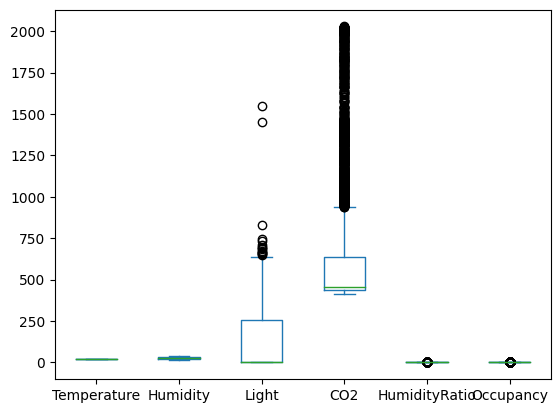

In [7]:
df.plot(kind='box')

In [8]:
Q1 = df['Light'].quantile(0.25)
Q3 = df['Light'].quantile(0.75)
IQR = Q3 - Q1

# Calculer les limites pour définir les valeurs aberrantes
seuil_inf = Q1 - 1.5 * IQR
seuil_sup = Q3 + 1.5 * IQR

# Filtrer le DataFrame pour exclure les outliers
df_filtre = df[(df['Light'] >= seuil_inf) & (df['Light'] <= seuil_sup)]

<AxesSubplot: >

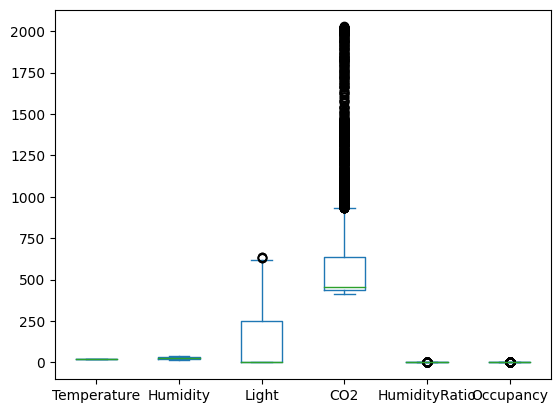

In [9]:
df_filtre.plot(kind='box')

In [10]:
Q1 = df_filtre['CO2'].quantile(0.25)
Q3 = df_filtre['CO2'].quantile(0.75)
IQR = Q3 - Q1

# Calculer les limites pour définir les valeurs aberrantes
seuil_inf = Q1 - 1.5 * IQR
seuil_sup = Q3 + 1.5 * IQR

# Filtrer le DataFrame pour exclure les outliers
df_filtre2 = df_filtre[(df_filtre['CO2'] >= seuil_inf) & (df_filtre['CO2'] <= seuil_sup)]

<AxesSubplot: >

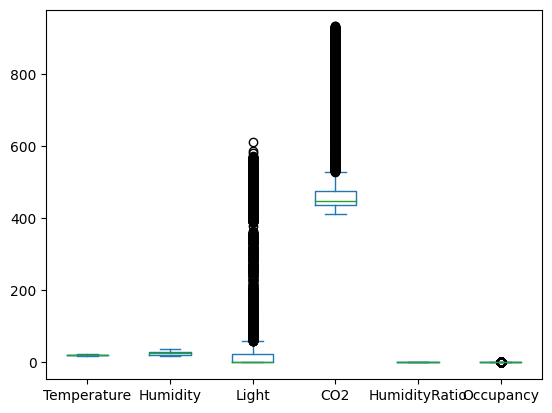

In [11]:
df_filtre2.plot(kind='box')

# 3. Visualisation et compréhension du DF

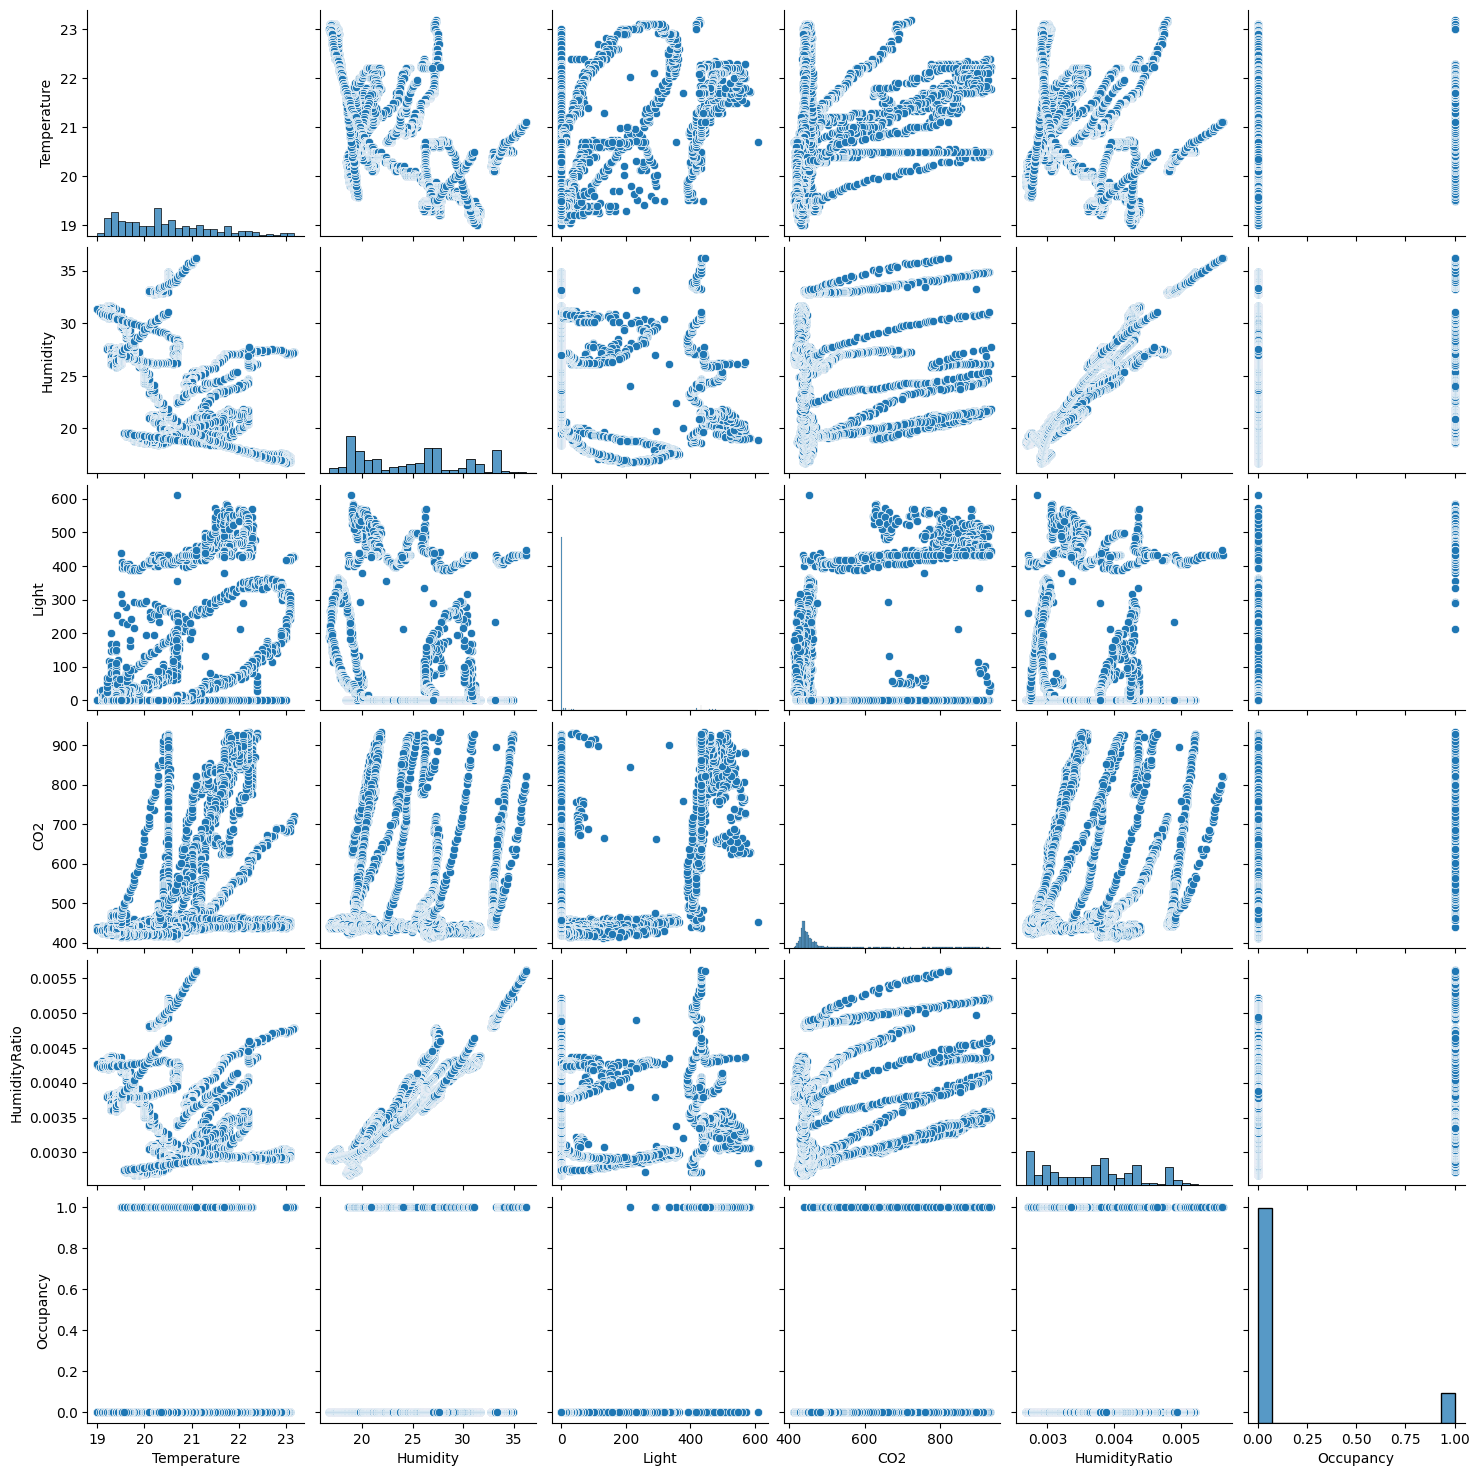

In [12]:
sns.pairplot(df_filtre2)

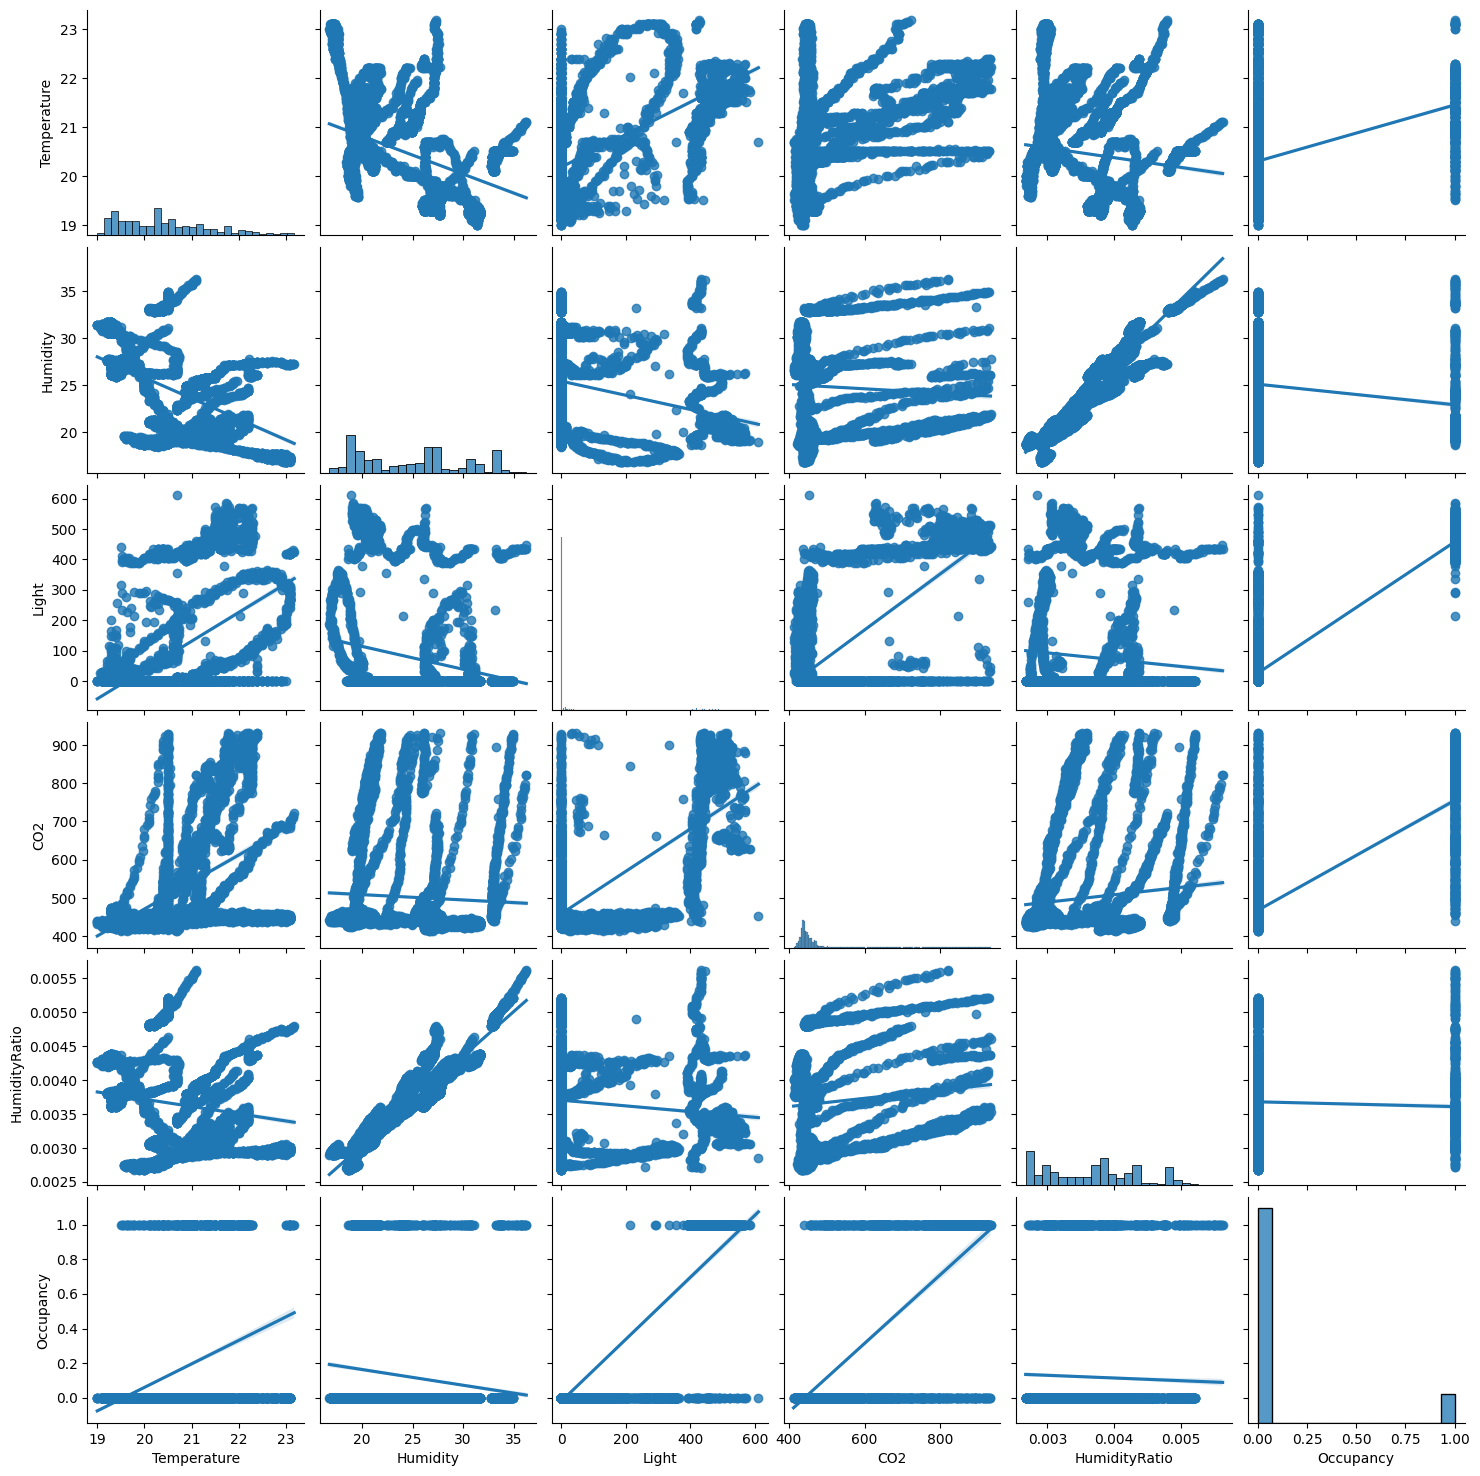

In [13]:
sns.pairplot(df_filtre2, kind="reg")

<AxesSubplot: >

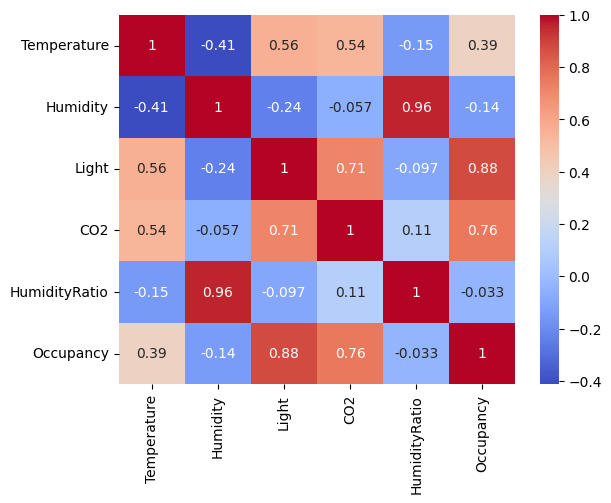

In [14]:
sns.heatmap(df_filtre2.corr(), annot=True, cmap='coolwarm')

# 4. Régression linéaire

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df_train, df_test = train_test_split(df_filtre2, test_size=0.2)

features_train = df_train[['Temperature', 'Light', 'CO2']]
target_train = df_train['Occupancy']

features_test = df_test[['Temperature', 'Light', 'CO2']]
target_test = df_test['Occupancy']

reg = LogisticRegression()
reg.fit(features_train, target_train)

pred_y_test = reg.predict(features_test)

score_train = reg.score(features_train, target_train)
score_test = reg.score(features_test, target_test)

In [16]:
score_test

0.9879688605803255

# 5. Impact des variables sur le modèle

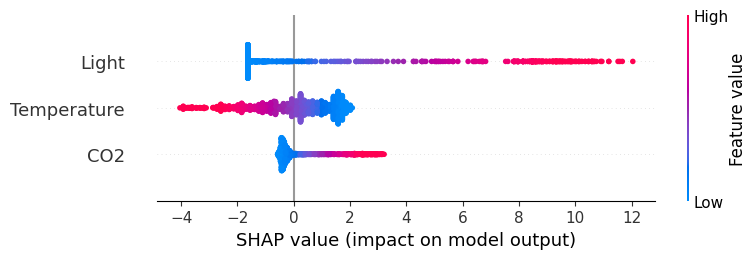

In [17]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Entraîner un modèle de régression logistique
model = LogisticRegression(max_iter=1000)
model.fit(features_train, target_train)
# Créer un explainer SHAP
explainer = shap.Explainer(model, features_train)
# Calculer les valeurs SHAP pour les données de test
shap_values = explainer(features_test)
# Visualiser l'importance des variables
shap.summary_plot(shap_values, features_test, feature_names=features_train.columns)

Importance relative des variables : Même si la température semble avoir un impact inverse, son influence globale peut être moins significative par rapport à la lumière et au CO2 pour prédire l'occupation. Bien qu'elle puisse varier de manière opposée, elle peut avoir un impact global moindre sur la prédiction.

# 6. Pycaret pour évaluation des autres modèles

In [18]:
from pycaret.classification import *

clf = setup(data = df_filtre2, target = 'Occupancy')

,Description,Value
0,Session id,372
1,Target,Occupancy
2,Target type,Binary
3,Original data shape,"(7063, 6)"
4,Transformed data shape,"(7063, 6)"
5,Transformed train set shape,"(4944, 6)"
6,Transformed test set shape,"(2119, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [19]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9966,0.9989,0.9865,0.9850,0.9856,0.9837,0.9837,0.5400
gbc,Gradient Boosting Classifier,0.9960,0.9990,0.9899,0.9772,0.9833,0.9810,0.9812,0.8750
lightgbm,Light Gradient Boosting Machine,0.9956,0.9994,0.9831,0.9804,0.9814,0.9789,0.9791,1.3780
rf,Random Forest Classifier,0.9953,0.9980,0.9865,0.9756,0.9807,0.9781,0.9783,0.5030
xgboost,Extreme Gradient Boosting,0.9953,0.9995,0.9882,0.9738,0.9808,0.9782,0.9783,0.1900
ada,Ada Boost Classifier,0.9947,0.9984,0.9831,0.9738,0.9782,0.9752,0.9754,0.5750
dt,Decision Tree Classifier,0.9943,0.9873,0.9781,0.9752,0.9764,0.9732,0.9733,0.0470
ridge,Ridge Classifier,0.9911,0.0000,1.0000,0.9323,0.9646,0.9595,0.9605,0.0260
qda,Quadratic Discriminant Analysis,0.9911,0.9957,1.0000,0.9323,0.9646,0.9595,0.9605,0.0560
lda,Linear Discriminant Analysis,0.9911,0.9955,1.0000,0.9323,0.9646,0.9595,0.9605,0.0300


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

# 7. Extra Trees Classifier

In [20]:
extra_trees = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9980,1.0000,1.0000,0.9833,0.9916,0.9904,0.9905
1,0.9960,0.9996,0.9831,0.9831,0.9831,0.9808,0.9808
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9960,0.9998,0.9667,1.0000,0.9831,0.9808,0.9809
4,0.9919,0.9997,0.9661,0.9661,0.9661,0.9615,0.9615
5,0.9939,0.9984,1.0000,0.9516,0.9752,0.9717,0.9721
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9980,0.9999,1.0000,0.9833,0.9916,0.9904,0.9905
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
evaluate_model(extra_trees)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…